# Basic imports and utils

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from layer import Layer
from neurons import RBF

## Constants

In [3]:
STANDARD_DEVIATION = 1

# RBF


We choose a gaußian activation function for a RBF neuron with it's derivatives $$y(x)=e^{-\frac{||x - c||^2}{2\sigma^2}}$$
$$\frac d{dc}y(x)=-\frac{x - c}{\sigma^2}e^{-\frac{||x - c||^2}{2\sigma^2}}$$
$$\frac d{dx}y(x)=\frac{x - c}{\sigma^2}e^{-\frac{||x - c||^2}{2\sigma^2}}$$

The standard deviation is going to be a fixed size hyper parameter.
## Definition of an RBF in this module
To use the broadcasting abilities of numpy as much as possible, we design functions in a way that they can update multiple neurons at once. For this we design the data structures for our neurons in a data oriented way. For this to work, the only limit put onto our neurons is that the input dimensions should be the same for all neurons.

Since we are going to work on images, and an image is a $(w, h, 3)$ float or integer array an RBF neuron needs to define the following things.

c: Should be a $(k_w, k_h, k_c)$ array representing the centers for this neuron

x: A subimage that should be defined by the outside function with the same dimesnions as c.

# Experiments


IndexError: index 1 is out of bounds for axis 0 with size 1

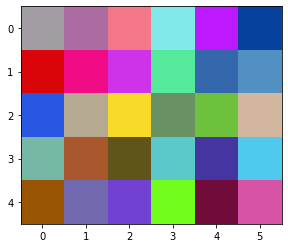

In [6]:
image = np.random.uniform(0, 1, size=[5, 6, 3])
plt.figure()
plt.imshow(image)
l = Layer(image.shape, 2, 3, (3,3,3), RBF)
l.propagate(image)